In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import pandas as pd
import json
import numpy as np
import sys
sys.path.append('../')
from dataset_creation.generate_data import pad_string
import evaluation_utils.eval_grouping_queries as queries
from evaluation_utils.plotting_utils import *
import evaluation_utils.exploration_utils as data_manip

In [47]:
result_dir = "../data/entailment_result_data/bart/"

data_files = ["physical_entail_perf_10.csv", "physical_entail_perf_10.csv", "social_entail_perf_10.csv", "temporal_entail_perf_10.csv"]

config_dir = "../data/truism_data/"

config_files = ["material_data_2.json", "physical_data_2.json", "social_data_2.json", "temporal_data_2.json"]

In [48]:
data = []

for file in data_files:
    full_path = result_dir + file
    data.append(pd.read_csv(full_path))

configs = []

for file in config_files:
    full_path = config_dir + file
    with open(full_path) as f:
        configs.append(json.load(f))

In [49]:
data[0].head()

,set_number,perturbation,asym_perturbs,ent_avg_score,contr_avg_score,ent_label_list,contr_label_list
0,0,original,original,0.0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
1,0,original,asymmetric_premise,0.0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
2,0,original,asymmetric_conclusion,0.0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
3,0,negation,original,0.0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,0,negation,asymmetric_premise,0.0,0.0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"


In [50]:
ent_sep_dict = {
                      "template" : [],
                      "set_number" : [],
                      "linguistic_operator" : [],
                      "asymetric_operator" : [],
                      "stat" : []
                    }


contr_sep_dict = {
                    "template" : [],
                    "set_number" : [],
                    "linguistic_operator" : [],
                    "asymetric_operator" : [],
                    "stat" : []
                 }


last_num = 0
for i, d in enumerate(data):
    ent_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                     ent_sep_dict,
                                                                     stat_name="ent_avg_score",
                                                                     last_num=last_num,
                                                                     option=1, 
                                                                     param_data=configs[i])
    
    contr_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                       contr_sep_dict,
                                                                       stat_name="contr_avg_score",
                                                                       last_num=last_num,
                                                                       option=1,
                                                                       param_data=configs[i])
    last_num += 20

In [51]:
ent_merged_dict = {
                         "template" : [],
                         "set_number" : [],
                         "perturbation" : [],
                         "stat" : []
                       }

contr_merged_dict = {
                      "template" : [],
                      "set_number" : [],
                      "perturbation" : [],
                      "stat" : []
                    }

last_num = 0
for i, d in enumerate(data):
    ent_merged_dict = data_manip.transform_results_to_merged_sql_dict(d, 
                                                                           ent_merged_dict,
                                                                           stat_name="ent_avg_score",
                                                                           last_num=last_num,
                                                                           option=1,
                                                                           param_data=configs[i])
    contr_merged_dict = data_manip.transform_results_to_merged_sql_dict(d, 
                                                                        contr_merged_dict,
                                                                        stat_name="contr_avg_score",
                                                                        last_num=last_num,
                                                                        option=1,
                                                                        param_data=configs[i])
    last_num += 20

In [52]:
ent_sep_df = pd.DataFrame.from_dict(ent_sep_dict)
contr_sep_df = pd.DataFrame.from_dict(contr_sep_dict)

ent_merged_df = pd.DataFrame.from_dict(ent_merged_dict)
contr_merged_df = pd.DataFrame.from_dict(contr_merged_dict)

In [56]:
print(ent_sep_df["stat"].mean(), contr_sep_df["stat"].mean())

0.15262499999999998 0.116375


In [32]:
ent_sep_df.head()

,template,set_number,linguistic_operator,asymetric_operator,stat
0,1,0,original,original,0.0
1,1,0,original,asymmetric_premise,0.0
2,1,0,original,asymmetric_conclusion,0.0
3,1,0,negation,original,0.0
4,1,0,negation,asymmetric_premise,0.0


In [33]:
ent_merged_df.head()

,template,set_number,perturbation,stat
0,1,0,original-original,0.0
1,1,0,original-asymmetric_premise,0.0
2,1,0,original-asymmetric_conclusion,0.0
3,1,0,negation-original,0.0
4,1,0,negation-asymmetric_premise,0.0


In [34]:
avg_ent_by_template = queries.run_template_grouping_query(ent_merged_df)
avg_contr_by_template = queries.run_template_grouping_query(contr_merged_df)

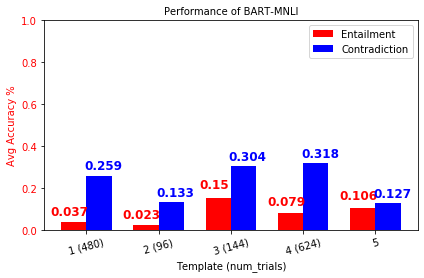

In [39]:
x_labels = ["1 (480)", "2 (96)", "3 (144)", "4 (624)", "5"]
x_label = "Template (num_trials)"
y_label = "Avg Accuracy %"
y_one_label = "Entailment"
data_one = [round(avg_ent_by_template[avg_ent_by_template["template"] == str(i)]["avg_stat"].item(), 3) for i in range(1, 6)]
y_two_label = "Contradiction"
data_two = [round(avg_contr_by_template[avg_contr_by_template["template"] == str(i)]["avg_stat"].item(), 3) for i in range(1, 6)]
title = "Performance of BART-MNLI"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, "red", "blue", title,
                     save_dir="",rand=0.33)



In [13]:
avg_ent_by_linguistic_op = queries.run_linguistic_operator_grouping_query(ent_sep_df)
avg_contr_by_linguistic_op = queries.run_linguistic_operator_grouping_query(contr_sep_df)

In [14]:
avg_ent_by_linguistic_op

,linguistic_operator,avg_stat,count
0,original,0.130000,60
1,negation,0.133333,60
2,antonym,0.056667,60
3,paraphrase,0.100000,60
4,paraphrase_inversion,0.055000,60
5,negation_antonym,0.050000,60
6,negation_paraphrase,0.148333,60
7,negation_paraphrase_inversion,0.101667,60


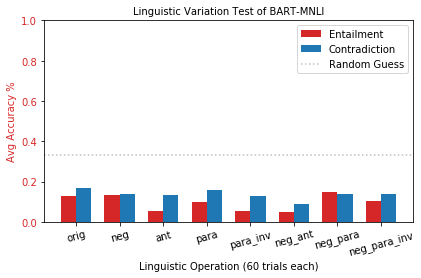

In [15]:
# Before Saving this, you must change what's going on inside autolabel to make sure 
# numbers are aligned to their correct positions
#
# Specifically you need to fiddle with this: x = rect.get_x() + rect.get_width() / 2
# in the bottom case, I use x = rect.get_x() + 8*rect.get_width() / 9

x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operation (60 trials each)"
y_label = "Avg Accuracy %"
y_one_label = "Entailment"
data_one = [round(row["avg_stat"], 3) for i, row in avg_ent_by_linguistic_op.iterrows()]
data_two = [round(row["avg_stat"], 3) for i, row in avg_contr_by_linguistic_op.iterrows()]
title = "Linguistic Variation Test of BART-MNLI"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",rand=0.33, add_nums_to_bars=False)




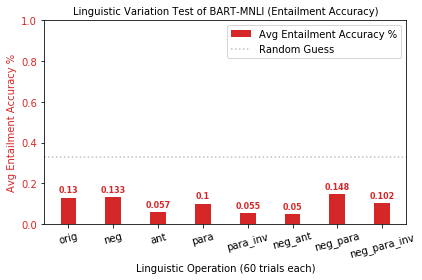

In [16]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operation (60 trials each)"
left_units = "Avg Entailment Accuracy %"
left_bar_data = [round(row["avg_stat"], 3) for i, row in avg_ent_by_linguistic_op.iterrows()]
title = "Linguistic Variation Test of BART-MNLI (Entailment Accuracy)"
display_bar_plot(x_labels, x_label, left_units, left_bar_data, title, color="tab:red",
                 save_dir="../data/analyzed_entailment_data/bart/", rand=0.33, small_title=True)

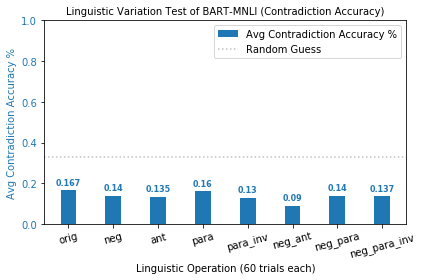

In [17]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operation (60 trials each)"
left_units = "Avg Contradiction Accuracy %"
left_bar_data = [round(row["avg_stat"], 3) for i, row in avg_contr_by_linguistic_op.iterrows()]
title = "Linguistic Variation Test of BART-MNLI (Contradiction Accuracy)"
display_bar_plot(x_labels, x_label, left_units, left_bar_data, title, color="tab:blue",
                 save_dir="../data/analyzed_entailment_data/bart/", rand=0.33, small_title=True)

In [18]:
avg_ent_by_logical_op = queries.run_asymetric_operator_grouping_query(ent_sep_df)
avg_contr_by_logical_op = queries.run_asymetric_operator_grouping_query(contr_sep_df)

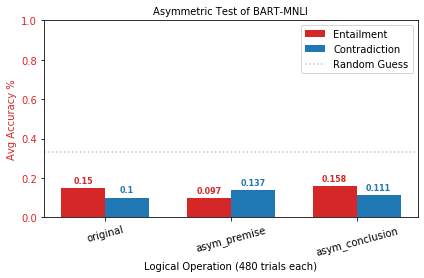

In [21]:
x_labels = ["original", "asym_premise", "asym_conclusion"]
x_label = "Logical Operation (480 trials each)"
y_label = "Avg Accuracy %"
y_one_label = "Entailment"
data_one = [round(row["avg_stat"], 3) for i, row in avg_ent_by_logical_op.iterrows()]
y_two_label = "Contradiction"
data_two = [round(row["avg_stat"], 3) for i, row in avg_contr_by_logical_op.iterrows()]
title = "Asymmetric Test of BART-MNLI"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",rand=0.33)

In [22]:
material_more_less = data_manip.filter_data_into_more_less_by_orig_comparison(data[0],
                                                                              configs[0],
                                                                              option=1)

physical_more_less = data_manip.filter_data_into_more_less_by_orig_comparison(data[1],
                                                                              configs[1],
                                                                              option=1)

social_more_less = data_manip.filter_data_into_more_less_by_orig_comparison(data[2],
                                                                            configs[2],
                                                                            option=1)


In [23]:
more = [material_more_less[0], physical_more_less[0], social_more_less[0]]
less = [material_more_less[1], physical_more_less[1], social_more_less[1]]

In [24]:
more_ent_sep_dict = {
                           "set_number" : [],
                           "linguistic_operator" : [],
                           "asymetric_operator" : [],
                           "stat" : []
                         }


more_contr_sep_dict = {
                         "set_number" : [],
                         "linguistic_operator" : [],
                         "asymetric_operator" : [],
                         "stat" : []
                      }


last_num = 0
for i, d in enumerate(more):
    more_ent_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                               more_ent_sep_dict,
                                                                               stat_name="ent_avg_score",
                                                                               last_num=last_num,
                                                                               option=1)
    more_contr_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                            more_contr_sep_dict,
                                                                            stat_name="contr_avg_score",
                                                                            last_num=last_num,
                                                                            option=1)
    last_num += 10

In [25]:
less_ent_sep_dict = {
                           "set_number" : [],
                           "linguistic_operator" : [],
                           "asymetric_operator" : [],
                           "stat" : []
                         }


less_contr_sep_dict = {
                         "set_number" : [],
                         "linguistic_operator" : [],
                         "asymetric_operator" : [],
                         "stat" : []
                      }


last_num = 0
for i, d in enumerate(less):
    less_ent_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                               less_ent_sep_dict,
                                                                               stat_name="ent_avg_score",
                                                                               last_num=last_num,
                                                                               option=1)
    less_contr_sep_dict = data_manip.transform_results_to_seperate_sql_dict(d,
                                                                            less_contr_sep_dict,
                                                                            stat_name="contr_avg_score",
                                                                            last_num=last_num,
                                                                            option=1)
    last_num += 10

In [26]:
more_ent_sep_df = pd.DataFrame.from_dict(more_ent_sep_dict)
more_contr_sep_df = pd.DataFrame.from_dict(more_contr_sep_dict)

less_ent_sep_df = pd.DataFrame.from_dict(less_ent_sep_dict)
less_contr_sep_df = pd.DataFrame.from_dict(less_contr_sep_dict)

In [27]:
more_avg_ent_by_linguistic_op = queries.run_linguistic_operator_grouping_query(more_ent_sep_df)
less_avg_ent_by_linguistic_op = queries.run_linguistic_operator_grouping_query(less_ent_sep_df)

more_avg_contr_by_linguistic_op = queries.run_linguistic_operator_grouping_query(more_contr_sep_df)
less_avg_contr_by_linguistic_op = queries.run_linguistic_operator_grouping_query(less_contr_sep_df)

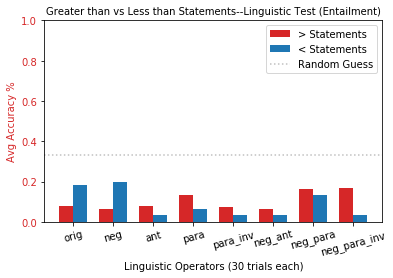

In [28]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operators (30 trials each)"
y_label = "Avg Accuracy %"
y_one_label = "> Statements"
data_one = [round(row["avg_stat"], 3) for i, row in more_avg_ent_by_linguistic_op.iterrows()]
y_two_label = "< Statements"
data_two = [round(row["avg_stat"], 3) for i, row in less_avg_ent_by_linguistic_op.iterrows()]
title = "Greater than vs Less than Statements--Linguistic Test (Entailment)"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",
                     add_nums_to_bars=False, rand=0.33)

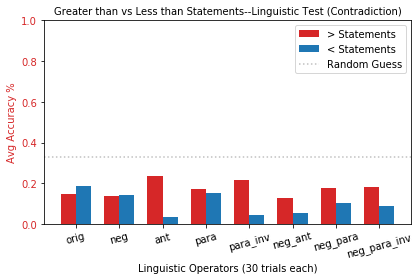

In [29]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operators (30 trials each)"
y_label = "Avg Accuracy %"
y_one_label = "> Statements"
data_one = [round(row["avg_stat"], 3) for i, row in more_avg_contr_by_linguistic_op.iterrows()]
y_two_label = "< Statements"
data_two = [round(row["avg_stat"], 3) for i, row in less_avg_contr_by_linguistic_op.iterrows()]
title = "Greater than vs Less than Statements--Linguistic Test (Contradiction)"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",
                     add_nums_to_bars=False, rand=0.33, small_title=True)

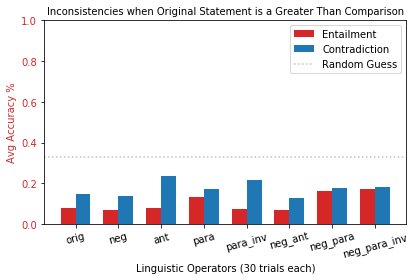

In [30]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operators (30 trials each)"
y_label = "Avg Accuracy %"
y_one_label = "Entailment"
data_one = [round(row["avg_stat"], 3) for i, row in more_avg_ent_by_linguistic_op.iterrows()]
y_two_label = "Contradiction"
data_two = [round(row["avg_stat"], 3) for i, row in more_avg_contr_by_linguistic_op.iterrows()]
title = "Inconsistencies when Original Statement is a Greater Than Comparison"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",
                     add_nums_to_bars=False, small_title=True, rand=0.33)

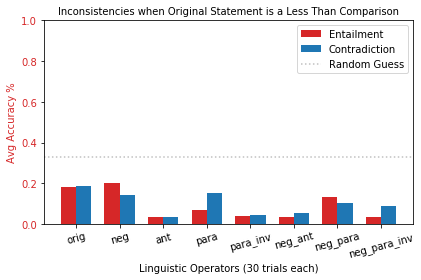

In [31]:
x_labels = ["orig", "neg", "ant", "para", "para_inv", "neg_ant", "neg_para", "neg_para_inv"]
x_label = "Linguistic Operators (30 trials each)"
y_label = "Avg Accuracy %"
y_one_label = "Entailment"
data_one = [round(row["avg_stat"], 3) for i, row in less_avg_ent_by_linguistic_op.iterrows()]
y_two_label = "Contradiction"
data_two = [round(row["avg_stat"], 3) for i, row in less_avg_contr_by_linguistic_op.iterrows()]
title = "Inconsistencies when Original Statement is a Less Than Comparison"
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",
                     add_nums_to_bars=False, small_title=True, rand=0.33)

In [32]:
more_avg_ent_by_logical_op = queries.run_asymetric_operator_grouping_query(more_ent_sep_df)
less_avg_ent_by_logical_op = queries.run_asymetric_operator_grouping_query(less_ent_sep_df)

more_avg_contr_by_logical_op = queries.run_asymetric_operator_grouping_query(more_contr_sep_df)
less_avg_contr_by_logical_op = queries.run_asymetric_operator_grouping_query(less_contr_sep_df)

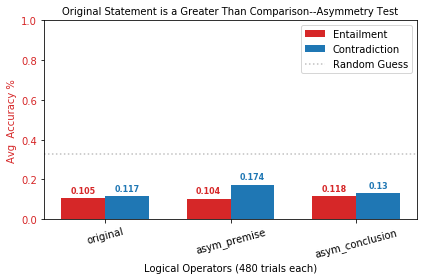

In [34]:
x_labels = ["original", "asym_premise", "asym_conclusion"]
x_label = "Logical Operators (480 trials each)"
y_label = "Avg  Accuracy %"
title = "Original Statement is a Greater Than Comparison--Asymmetry Test"
y_one_label = "Entailment"
data_one = [round(row["avg_stat"], 3) for i, row in more_avg_ent_by_logical_op.iterrows()]
y_two_label = "Contradiction"
data_two = [round(row["avg_stat"], 3) for i, row in more_avg_contr_by_logical_op.iterrows()]
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",
                     add_nums_to_bars=True, small_title=True, rand=0.33)

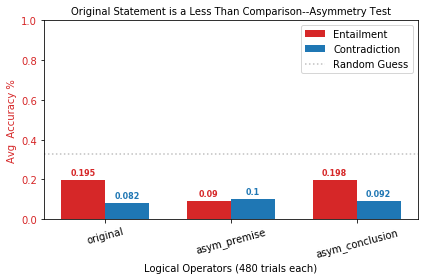

In [38]:
x_labels = ["original", "asym_premise", "asym_conclusion"]
x_label = "Logical Operators (480 trials each)"
y_label = "Avg  Accuracy %"
title = "Original Statement is a Less Than Comparison--Asymmetry Test"
y_one_label = "Entailment"
data_one = [round(row["avg_stat"], 3) for i, row in less_avg_ent_by_logical_op.iterrows()]
y_two_label = "Contradiction"
data_two = [round(row["avg_stat"], 3) for i, row in less_avg_contr_by_logical_op.iterrows()]
display_two_bar_plot(x_labels, x_label, y_label, y_one_label, y_two_label, data_one,
                     data_two, title,
                     save_dir="../data/analyzed_entailment_data/bart/",
                     add_nums_to_bars=True, small_title=True, rand=0.33)

In [39]:
set_ent_df = queries.run_set_grouping_query(ent_sep_df)
set_contr_df = queries.run_set_grouping_query(contr_sep_df)

In [37]:
# truisms_data

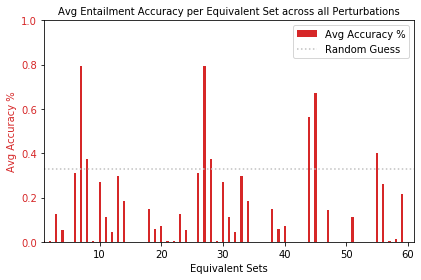

In [40]:
x_label = "Equivalent Sets"
left_units = "Avg Accuracy %"
left_bar_data = [round(row["avg_stat"], 3) for i, row in set_ent_df.iterrows()]
# len(left_bar_data), len(x_labels)
title = "Avg Entailment Accuracy per Equivalent Set across all Perturbations"
display_bar_plot((1,61), x_label, left_units, left_bar_data, title, color="tab:red",
                 save_dir="../data/analyzed_entailment_data/bart/",
                 add_nums_to_bars=False, label_x_ticks=False, small_title=True, rand=0.33)

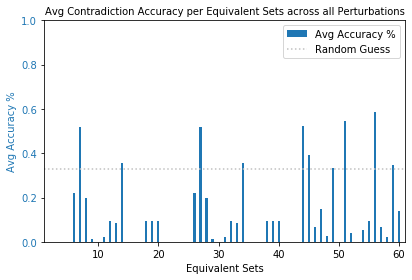

In [41]:
x_label = "Equivalent Sets"
left_units = "Avg Accuracy %"
left_bar_data = [round(row["avg_stat"], 3) for i, row in set_contr_df.iterrows()]
# left_bar_data
title = "Avg Contradiction Accuracy per Equivalent Sets across all Perturbations"
display_bar_plot((1,61), x_label, left_units, left_bar_data, title, color="tab:blue",
                 save_dir="../data/analyzed_entailment_data/bart/",
                 add_nums_to_bars=False, label_x_ticks=False, small_title=True, rand=0.33)